# Chapter 8 Tree-Based Methods Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image
from io import StringIO
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

from src import ch8_utils

%matplotlib inline

### 8.2. Why is boosting using depth-one trees (or stumps) analogous to an additive model?

An additive model is one in which each variable is applied its own formula. "Stumped Boosting" more or less performs the same exercise by splitting one feature for each tree.


### 8.5. Ten bootstrapped samples question.

If I use the **majority-vote approach**, the predicted classification is **red**. If I apply **average probability**, the predicted classification is **green**.

In [ ]:
q5_arr = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
q5_arr.mean()

### 8.5. A detailed explanation of the algorithm that is used to fit a regression tree.

- 

## Conceptual

### 8.7. Create a plot displaying the test error resulting from a random forest on the Boston dataset for a more comprehensive range of values for "max_features" and "n_estimators."

In [2]:
url_path = os.path.abspath('..')
boston = pd.read_csv(url_path + '/data/Boston.csv')

X = boston.drop('medv', axis=1)
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [3]:
num_trees = np.arange(1, 502, 50)
num_features = np.arange(2, X_train.shape[1], 2)
rf_mse_df = pd.DataFrame(index=num_trees)

for feature_count in num_features:
    mse_tmp_arr = []
    for tree_count in num_trees:
        regr = RandomForestRegressor(n_estimators=tree_count, max_features=feature_count)
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        mse_tmp_arr.append(mse)
    
    rf_mse_df[str(feature_count)+ '_features'] = pd.Series(mse_tmp_arr,index=num_trees)

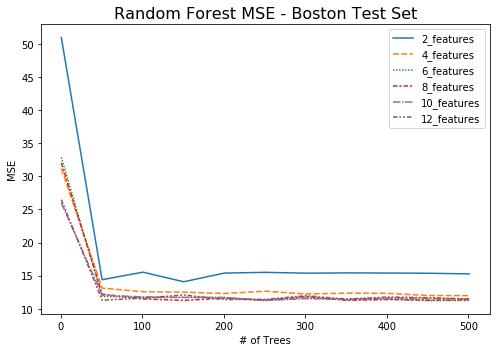

In [4]:
fig, ax = plt.subplots(figsize=(7,5))

sns.lineplot(data=rf_mse_df)
ax.set_title('Random Forest MSE - Boston Test Set', fontsize=16)
ax.set_xlabel('# of Trees')
ax.set_ylabel('MSE')
fig.tight_layout();

The lowest test MSE of **11.072796** was acehieved using **351 estimators** and **6 features**. In general, the models with **>=6 features** performed similary when **>= 51 estimators**. When using 12 features, there seemed to be a bit of overfitting as the MSE increased.

## 8.8. Apply a regression to the Carseats dataset to predict sales.

In [5]:
url_path = os.path.abspath('..')
carseats = pd.read_csv(url_path + '/data/Carseats.csv')

# Feature engineering
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = carseats['Urban'].map({'No': 0, 'Yes':1})
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1})

carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,0,42,17,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1
4,4.15,141,64,3,340,128,0,38,13,1,0


In [6]:
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
dtree_regr = DecisionTreeRegressor(max_depth = 5)
dtree_regr.fit(X_train, y_train)
pred = dtree_regr.predict(X_test)

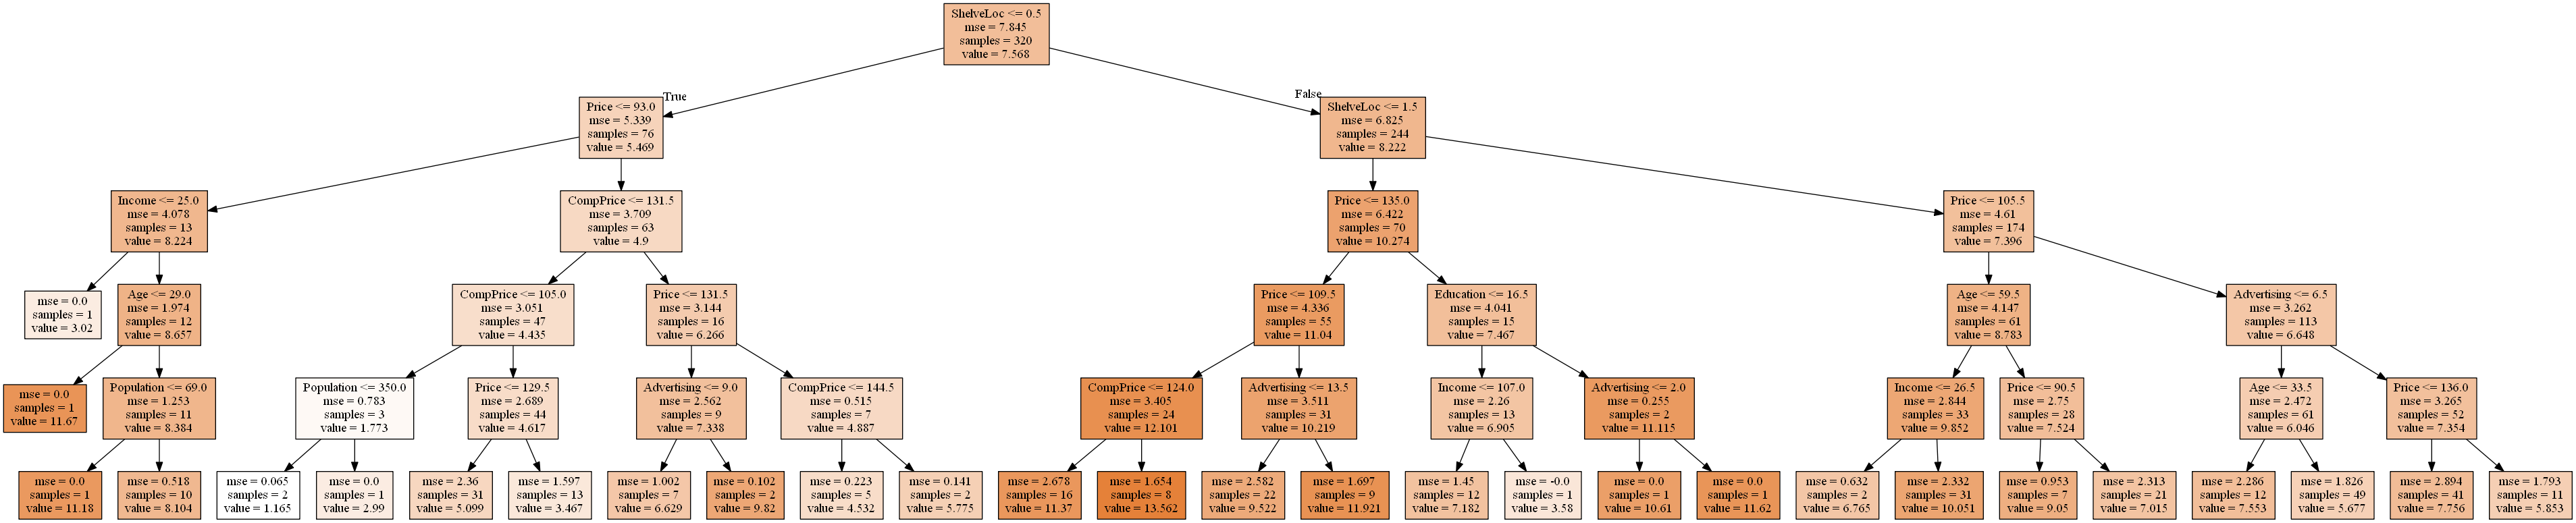

In [8]:
tree_viz, = ch8_utils.print_tree(dtree_regr, X_train.columns, class_names=None, filled=True)
Image(tree_viz.create_png())

In [9]:
print('Decision Tree MSE: {:.4}'.format(mean_squared_error(y_test, pred)))

Decision Tree MSE: 6.333


It seems that the sales of carseats is more influenced by adveristing/marketing than product quality/safety. In general, the better the shelve base, the greater the sales. Also, the more affluent the market/consumer - e.g., income and competitive product price - the greater the sales.

In summary, if a company targets the lower economic class, the less goods it is expected to sell

#### Use cross-validation to determine optimal level of tree complexity.

In [ ]:
max_depth_arr = np.arange(1, 11)
avg_train_mse_arr = []
train_cross_val_df = pd.DataFrame()
test_mse_arr = []

for depth in max_depth_arr:
    regr = DecisionTreeRegressor(max_depth=depth)
    regr.fit(X_train, y_train)
    
    # training set metrics
    train_cross_val_arr = -1 * cross_val_score(regr, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    train_cross_val_df[str(depth) + '_depth'] = train_cross_val_arr
    
    train_mse = np.mean(train_cross_val_arr)
    avg_train_mse_arr.append(train_mse)
    
    # test set
    pred = regr.predict(X_test)
    test_mse = mean_squared_error(pred, y_test)
    test_mse_arr.append(test_mse)
    

In [11]:
train_c_val_df, avg_train_mse_arr, test_mse_arr = ch8_utils.calc_train_test_mse_decision_tree_regr(X_train,
                                                                                                X_test,
                                                                                                y_train,
                                                                                                y_test,
                                                                                                10,
                                                                                                10)

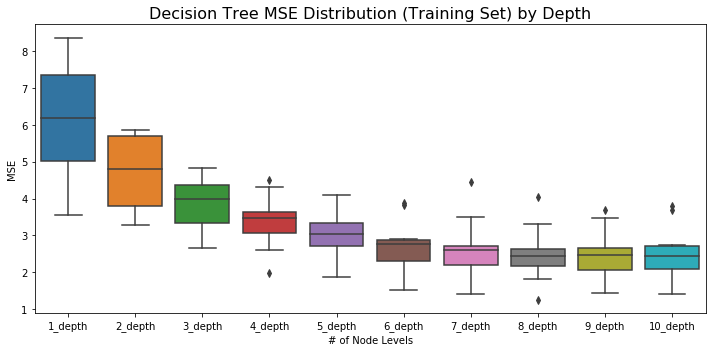

In [18]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=train_c_val_df, ax=ax)
ax.set_title('Decision Tree MSE Distribution (Training Set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

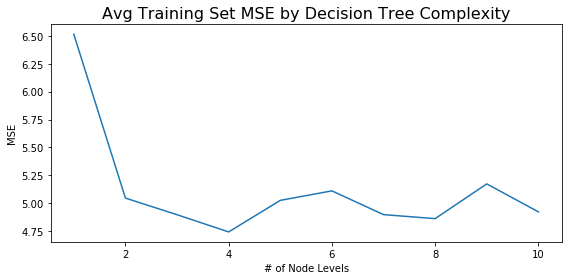

In [13]:
max_depth_arr = np.arange(1, 11)

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=avg_train_mse_arr, ax=ax)
ax.set_title('Avg Training Set MSE by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

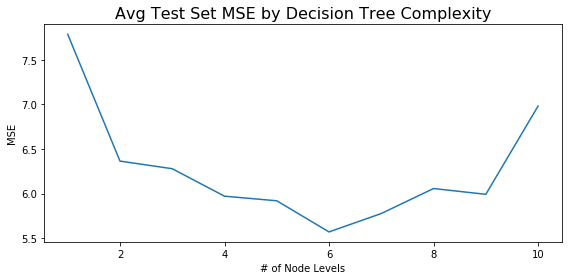

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=test_mse_arr, ax=ax)
ax.set_title('Avg Test Set MSE by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

A depth of 7 produces the optimal MSE of ~5.6, which is lower than allowing the tree to grow.

### 8.4.d. Apply the previous approach to a bagging model.

In [15]:
num_features = X.shape[1]

train_c_val_df, avg_train_mse_arr, test_mse_arr = ch8_utils.calc_train_test_mse_bagging_regr(X_train,
                                                                                            X_test,
                                                                                            y_train,
                                                                                                y_test,
                                                                                                10,
                                                                                                10)

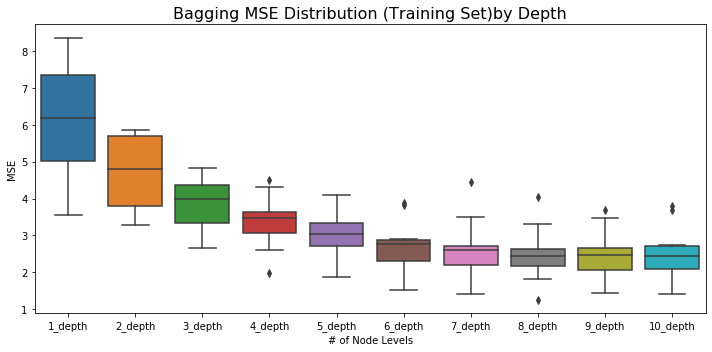

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=train_c_val_df, ax=ax)
ax.set_title('Bagging MSE Distribution (Training Set)by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

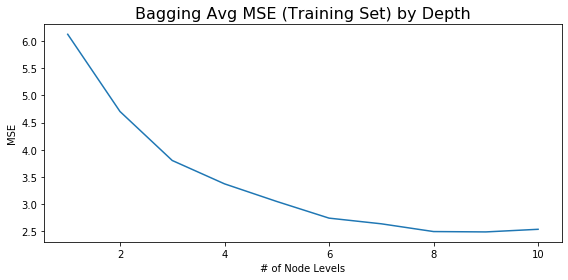

In [20]:
max_depth_arr = np.arange(1, 11)

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=avg_train_mse_arr, ax=ax)
ax.set_title('Bagging Avg MSE (Training Set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

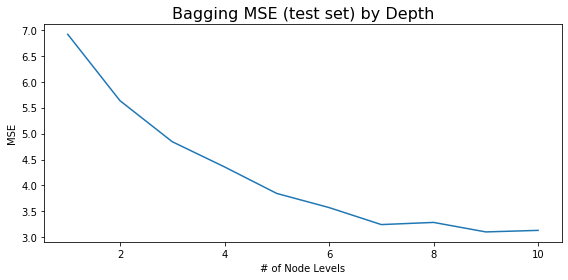

In [21]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=test_mse_arr, ax=ax)
ax.set_title('Bagging MSE (test set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

In [ ]:
gi